In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy import units as u
%config InlineBackend.figure_format = 'retina'
import pyneb as pn
from scipy.ndimage import gaussian_filter1d

In [3]:
c = const.c.cgs.value   
k_B = const.k_B.cgs.value  
m_p = const.m_p.cgs.value 

O3 = pn.Atom('O', 3)   # O3
H1 = pn.RecAtom('H', 1)  # H-beta


In [4]:

def getflux(ion, wl, T, ne, ni = None):
    if ni is None:
        ni = ne * 1e-4 # rough estimate from ISM densities

    eps = ion.getEmissivity(tem=T, den=ne, wave=wl)
    # emissivity per unit volume
    j = eps * ne * ni
    F = j #ignoring geometry and distance for now
    return F

# pure thermal broadening 
def broaden(wl0, T, mass):
    v_th = np.sqrt(2 * k_B * T / mass)
    return wl0 * (v_th / c)


In [5]:
def getgauss(wl, wl0, sigma, flux):
    amp = flux / (np.sqrt(2 * np.pi) * sigma)
    profile = amp * np.exp(- ((wl - wl0) / (2 * sigma))**2)
    return profile, amp

In [ ]:
hex = np.loadtxt('stdarray.csv', delimiter=',', skiprows=13, usecols=(5,6), max_rows=552)
sorted_data = []  # sort the data in a snake-like pattern
for i, y in enumerate(np.unique(hex[:, 1])):  # get all vertical values
    row_mask = hex[:, 1] == y
    row_data = hex[row_mask]
    sorted_indices = np.argsort(row_data[:, 0])  # sort by x coord
    if i % 2 == 0:  # even index rows go right-to-left, odd go left-to-right
        sorted_indices = sorted_indices[::-1]
    sorted_data.extend(row_data[sorted_indices])
hex = np.array(sorted_data)

In [53]:
import numpy as np

def vlos_shell_ifu(x, y, R, k, side="near"):
    """
    Line-of-sight velocity for a thin expanding spherical shell with v ∝ 1/R,
    projected onto an IFU (x, y) plane.

    Parameters
    ----------
    x, y : 2D arrays
        Spaxel coordinates in the plane of the sky (same units as R).
        e.g., from np.meshgrid over arcsec or physical units.
    R : float
        Radius of the expanding shell (same units as x, y).
    k : float
        Velocity scale such that v(r) = k / r.
        For a thin shell at radius R, v_radial = k / R.
    side : {"near", "far", "both"}, optional
        - "near": return LOS velocity for the near side (z > 0).
        - "far":  return LOS velocity for the far side (z < 0).
        - "both": return a tuple (v_near, v_far).

    Returns
    -------
    v_los : 2D array or tuple of 2D arrays
        Line-of-sight velocity field(s) in the same shape as x and y.
        Outside the projected sphere (rho > R), values are 0.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    rho2 = x**2 + y**2
    inside = rho2 <= R**2

    # z on the shell for pixels that intersect it
    z = np.zeros_like(x, dtype=float)
    z[inside] = np.sqrt(R**2 - rho2[inside])   # near side (z > 0)

    # radial speed on the shell is k / R
    v_rad = k / R

    # v_los = v_rad * (z / R) = k * z / R^2
    v_near = np.zeros_like(x, dtype=float)
    v_near[inside] = v_rad * (z[inside] / R)

    v_far = -v_near  # symmetry: far side is opposite sign

    if side == "near":
        return v_near
    elif side == "far":
        return v_far
    elif side == "both":
        return v_near, v_far
    else:
        raise ValueError("side must be 'near', 'far', or 'both'")


In [74]:
# Make an IFU grid (spaxels) in arcsec
nx, ny = 23, 24
x_arr = np.linspace(-1.0, 1.0, nx)   # arcsec
y_arr = np.linspace(-1.0, 1.0, ny)
x, y = np.meshgrid(x_arr, y_arr)

R = 0.44     # shell radius in same units as x,y
k = 180.0    # velocity scale (km/s * R_unit)

v_near, v_far = vlos_shell_ifu(x, y, R, k, side="both")


In [75]:
c = 3e5  # km/s
lambda0 = 5007.0  # Angstrom, rest wavelength

lambda_obs = lambda0 * (1.0 + v_near / c)


In [36]:
def vlos(i, j, ic, jc, R, pix_scale):
    """
    LOS velocity for a thin expanding spherical shell with v ∝ 1/R,
    on an IFU grid defined by indices (i, j).

    Parameters
    ----------
    i, j : 2D arrays
        Index grids for the IFU spaxels (e.g. from np.indices).
        i ~ row (y direction), j ~ column (x direction).
    ic, jc : float
        Index coordinates of the IFU center (same convention as i, j).
        e.g. ic = (ny-1)/2, jc = (nx-1)/2
    R : float
        Shell radius in the same *physical units* as pix_scale * indices.
    k : float
        Velocity scale so that v(r) = k / r.
        On the shell, v_radial = k / R.
    pix_scale : float
        Physical size per spaxel (same units as R) – e.g. kpc/pixel or arcsec/pixel
        (as long as R is in the same units).
    side : {"near", "far", "both"}
        Which side of the shell to return.

    Returns
    -------
    v_los : 2D array or (2D, 2D)
        LOS velocity in same shape as i, j.
        Outside the projected sphere (rho > R), set to 0.
    """

    # convert indices -> on-sky physical coords
    # j -> x, i -> y
    x = (j - jc) * pix_scale
    y = (i - ic) * pix_scale

    rho2 = x**2 + y**2
    inside = rho2 <= R**2

    # z on the shell for pixels inside the projected circle (near side)
    z = np.zeros_like(x, dtype=float)
    z[inside] = np.sqrt(R**2 - rho2[inside])  # z > 0

    # radial speed is k / R, LOS proj is (z/R)
    v_rad = 1 / R
    v_near = np.zeros_like(x, dtype=float)
    v_near[inside] = v_rad * (z[inside] / R)  # = k * z / R**2

    v_far = -v_near  # symmetry

    return v_near, v_far


In [37]:
def sphere(r, vcenter, theta):
    vel = vcenter * np.cos(theta) 
    # assuming v scales as 1/R

    
    

def dopplershift(wl0, vel):
    return wl0 * (vel / c)

In [69]:
vlos(i, j, 27, 27, 50, 0.2)[0]

array([0.01975733, 0.01975333, 0.01974922, 0.01974499, 0.01974064,
       0.01973619, 0.01973162, 0.01972693, 0.01972214, 0.01971722,
       0.0197122 , 0.01970706, 0.0197018 , 0.01969643, 0.01969095,
       0.01968535, 0.01967964, 0.01967381, 0.01966787, 0.01966182,
       0.01965564, 0.01964936, 0.01964296, 0.01965159, 0.01965794,
       0.01966416, 0.01967028, 0.01967627, 0.01968216, 0.01968793,
       0.01969358, 0.01969912, 0.01970454, 0.01970985, 0.01971505,
       0.01972013, 0.0197251 , 0.01972995, 0.01973469, 0.01973932,
       0.01974383, 0.01974823, 0.01975251, 0.01975668, 0.01976074,
       0.01976469, 0.01976803, 0.01976403, 0.01975992, 0.01975569,
       0.01975135, 0.0197469 , 0.01974233, 0.01973765, 0.01973285,
       0.01972795, 0.01972292, 0.01971778, 0.01971253, 0.01970717,
       0.01970169, 0.01969609, 0.01969038, 0.01968456, 0.01967862,
       0.01967257, 0.0196664 , 0.01966012, 0.01965372, 0.01966218,
       0.01966852, 0.01967475, 0.01968086, 0.01968685, 0.01969

In [6]:
# vel in km/s
# ne is electron density in cm^-3

def getspectrum(wl, T, ne, lines, vel):
    wl = np.asarray(wl)
    
    spectrum = np.zeros_like(wl)
    info = []

    vel = vel * 1e5 # converting to cm/s

    for line in lines:
        ion = line['ion']
        lam0 = line['wl']
        mass = line['mass']
        ni = line.get('ni', 1e-4 * ne)

        # flux
        F = getflux(ion, lam0, T, ne, ni= ni)
    
        thermal = broaden(lam0, T, mass)

        # broadening from bulk motion
        doppler = lam0 * (vel / c)
        
        sigma = np.sqrt(thermal**2 + doppler**2)

        prof, amp = getgauss(wl, lam0, sigma, F)

        spectrum += prof
        info.append({
            'wl': lam0,
            'flux': F,
            'sigma': sigma,
            'amp': amp,
        })

    spectrum = np.array(spectrum)
    return spectrum, info


In [25]:
wl = np.linspace(4850, 5050, 5000)

T = 2600
ne = 30
vel = 20

m_H = m_p
m_O = 16 * m_p

lines = [
    {'ion': H1,  'wl': 4861, 'mass': m_H},
    {'ion': O3,  'wl': 4959, 'mass': m_O},
    {'ion': O3,  'wl': 5007, 'mass': m_O}]

spec, info = getspectrum(wl, T, ne, lines, vel)

In [26]:
hdul = fits.open('data/smc_snr/b0885.norm.dc.fits')
flux = hdul[0].data
hdr = hdul[0].header

if 'CD1_1' in hdr:
    wave = hdr['CRVAL1'] + hdr['CD1_1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)
else:
    wave = hdr['CRVAL1'] + hdr['CDELT1'] * (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1)


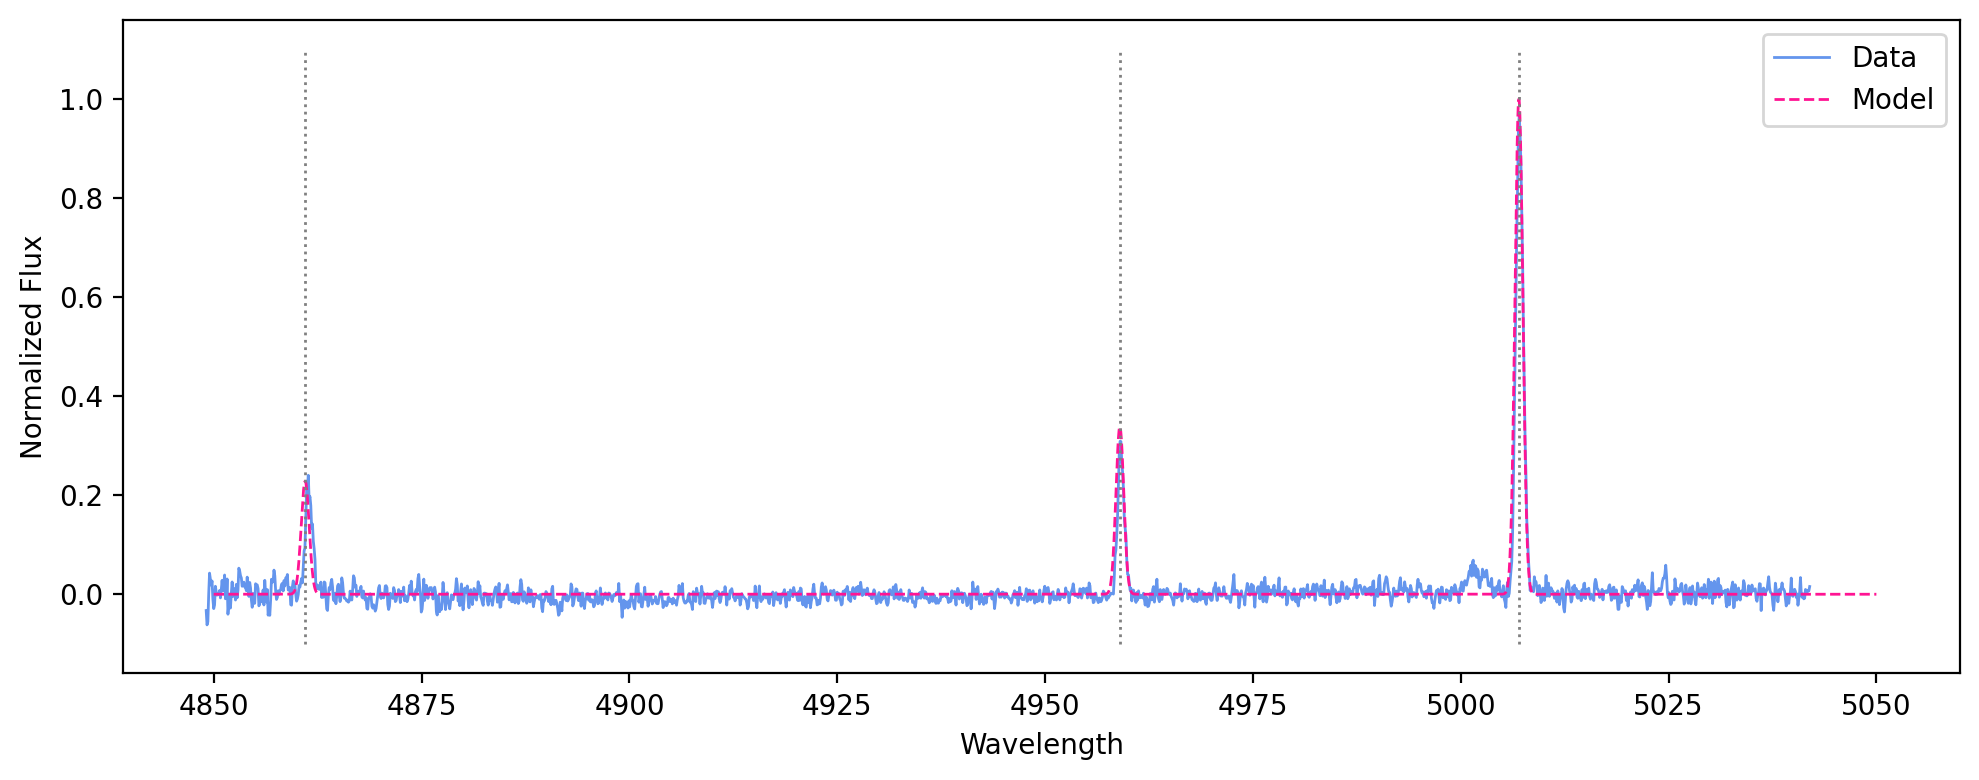

In [28]:
z = (5010 - 5007) / 5007 # our data has offset, correcting for that

plt.figure(figsize=(10,4))

#plt.plot(wave, (flux[0] - np.median(flux[0])) / np.max(flux[0]), label='Data', lw = 1, color = 'cornflowerblue')

plt.plot(wave / (1 + z), (flux[0] - np.median(flux[0])) / np.max(flux[0]), label='Data', lw = 1, color = 'cornflowerblue')
plt.plot(wl, spec/np.max(spec), label='Model', color = 'deeppink', ls = '--', lw = 1)
plt.vlines([4861, 4959, 5007], ymin=-0.1, ymax=1.1, color='gray', ls=':', lw=1)

plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.tight_layout()
